In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
AUTOTUNE = tf.data.experimental.AUTOTUNE 


In [2]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
image_size = [64,64]
batch_size = 32
epoch = 10

In [3]:
def train_data():
    tf.keras.preprocessing.image_dataset_from_directory(
    '../Alz_data/train/',
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=image_size,
    batch_size=batch_size,)

In [ ]:
train_data = train_data()

In [ ]:
print(train_data)

In [ ]:
train_data = init_data('train_data', '../Alz_data/train/', 'training', 123, [64,64], 32)

In [ ]:
val_data = init_data('val_data', '../Alz_data/train/', 'validation', 123, [64,64], 32)

In [4]:
train_data = tf.keras.preprocessing.image_dataset_from_directory(
    '../Alz_data/train/',
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=image_size,
    batch_size=batch_size,
)

Found 2612 files belonging to 2 classes.
Using 2090 files for training.


In [5]:
val_data = tf.keras.preprocessing.image_dataset_from_directory(
    '../Alz_data/train',
        validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(64,64),
    batch_size=batch_size,
)

Found 2612 files belonging to 2 classes.
Using 522 files for validation.


In [ ]:
print(val_data)

In [6]:
class_names = ['ModerateDementia', 'NonDementia']
train_data.class_names = class_names
val_data.class_names = class_names

NUM_CLASSES = len(class_names)

In [7]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ]
    )
    
    return block

In [8]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [39]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
        tf.keras.Input(shape=(*image_size, 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
       # conv_block(256),
       # tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
       # dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

In [41]:
model.summary()

ValueError: This model has not yet been built. Build the model first by calling `build()` or calling `fit()` with some data, or specify an `input_shape` argument in the first layer(s) for automatic build.

In [40]:
model = build_model()

METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'), 
        tf.keras.metrics.FalseNegatives()
    ]
    
model.compile(
        optimizer='adam',
        loss=tf.losses.BinaryCrossentropy(),
        metrics=METRICS
    )

In [36]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 **(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.01, 20)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)



In [42]:
history = model.fit(
    train_data,
    validation_data=val_data,
#     callbacks=[lr_scheduler],
    epochs=epoch
)

Epoch 1/10
66/66 [==============================] - 17s 252ms/step - accuracy: 0.6120 - recall: 0.6148 - precision: 0.9836 - loss: 0.7277 - false_negatives_3: 790.0000 - val_precision: 0.9751 - val_recall: 1.0000 - val_false_negatives_3: 0.0000e+00 - val_loss: 0.4165 - val_accuracy: 0.9751
Epoch 2/10
66/66 [==============================] - 17s 254ms/step - accuracy: 0.7885 - recall: 0.7977 - precision: 0.9838 - loss: 0.4721 - false_negatives_3: 415.0000 - val_precision: 0.9751 - val_recall: 1.0000 - val_false_negatives_3: 0.0000e+00 - val_loss: 0.2607 - val_accuracy: 0.9751
Epoch 3/10
66/66 [==============================] - 17s 256ms/step - accuracy: 0.9110 - recall: 0.9254 - precision: 0.9829 - loss: 0.3084 - false_negatives_3: 153.0000 - val_precision: 0.9751 - val_recall: 1.0000 - val_false_negatives_3: 0.0000e+00 - val_loss: 0.1786 - val_accuracy: 0.9751
Epoch 4/10
66/66 [==============================] - 16s 244ms/step - accuracy: 0.9589 - recall: 0.9746 - precision: 0.9833 - lo

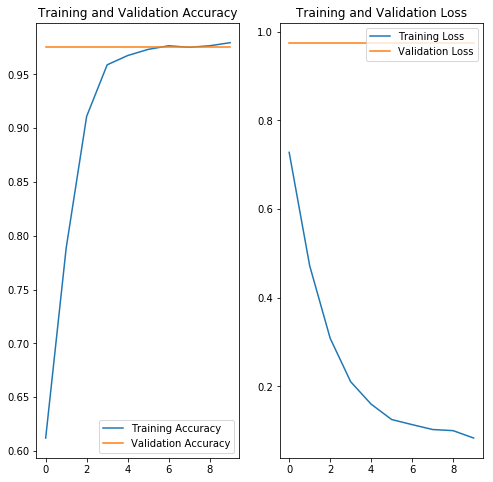

In [44]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
recall = history.history['recall']
# false_neg = history.history['false_negatives']


loss = history.history['loss']
val_loss = history.history['val_accuracy']

epochs_range = range(epoch)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [45]:
test_data = tf.keras.preprocessing.image_dataset_from_directory(
    '../Alz_data/test/',
    image_size=image_size,
    batch_size=batch_size,
)


Found 652 files belonging to 2 classes.


In [46]:
test_acc, test_recall, test_precision, test_loss = model.evaluate(test_data)

21/21 [==============================] - 2s 88ms/step - accuracy: 0.9816 - recall: 1.0000 - precision: 0.9816 - loss: 0.0884 - false_negatives_3: 0.0000e+00


ValueError: too many values to unpack (expected 4)

In [47]:
print('\nTest accuracy:', test_acc,
     '\nTest recall:', test_recall,
     '\nTest precision:', test_precision,
     '\nTest loss:', test_loss)


Test accuracy: 0.0983293354511261 
Test recall: 0.9815950989723206 
Test precision: 0.9815950989723206 
Test loss: 1.0


In [ ]:
model2 = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
    tf.keras.Input(shape=(*image_size, 3)),
    tf.keras.layers.Flatten(input_shape=(64,64)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])



model2.compile(
    optimizer='adam',
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy'])

simple = model2.fit(train_data, validation_data=val_data, epochs=epoch)

test_loss, test_acc = model.evaluate(train_data)

print('\nTest accuracy:', test_acc)

In [ ]:

# test_data = test_data.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
print(test_data)

In [ ]:
test_loss, test_acc = model.evaluate(test_data)

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_accuracy']

epochs_range = range(epoch)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()